In [1]:
import os  # noqa

os.environ["PAT_MAXIMUM_BATCH_SIZE"] = "5"  # noqa
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # noqa
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # noqa

from patato.useful_utilities import add_axis_label
from matplotlib_scalebar.scalebar import ScaleBar
import patato as pat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob

import scienceplots  # noqa: F401

matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["figure.constrained_layout.use"] = True
plt.style.use(["science", "nature", "no-latex"])

rgbs = np.load("../data/reflectance/intermediate_results.npz")["rgbs"]

In [2]:
files = sorted(glob.glob("../data/simulations/acuity acoustic simulation/acoustic_melanosome_realistic_*.npz"))
files_loaded = [np.load(x) for x in files]

In [3]:
time_series = [
    pat.PATimeSeries.from_numpy(f["ts"][None], f["wavelength"], f["fs"], f["c"])
    for f in files_loaded
]


def reconstruct(f, ts):
    geometry = f["geometry"]
    pre = pat.DefaultMSOTPreProcessor()
    ts_filtered, settings, _ = pre.run(ts, None, detectors=geometry)
    rec = pat.Backprojection(
        field_of_view=((-0.02, 0.02), (0.0, 0.0), (-0.015, 0.003)),
        n_pixels=(668, 1, 300),
    )
    image, _, _ = rec.run(ts_filtered, None, speed_of_sound=f["c"], **settings)
    umer = pat.SpectralUnmixer(
        chromophores=["Hb", "HbO2"], wavelengths=f["wavelength"], rescaling_factor=1
    )
    so2er = pat.SO2Calculator()
    thber = pat.THbCalculator()
    um, _, _ = umer.run(image, None)
    so2, _, _ = so2er.run(um, None)
    thb, _, _ = thber.run(um, None)
    return f["wavelength"], image, so2, f["mvf"], thb

In [4]:
reconstructions = [reconstruct(f, ts) for f, ts in zip(files_loaded, time_series)]

/Users/else01/Documents/Code Development/patato/patato/processing/jax_preprocessing_algorithm.py:234: UserWarning: No energy correction factor applied.
  warnings.warn("No energy correction factor applied.")
/Users/else01/Documents/Code Development/patato/patato/processing/jax_preprocessing_algorithm.py:234: UserWarning: No energy correction factor applied.
  warnings.warn("No energy correction factor applied.")
/Users/else01/Documents/Code Development/patato/patato/processing/jax_preprocessing_algorithm.py:234: UserWarning: No energy correction factor applied.
  warnings.warn("No energy correction factor applied.")
/Users/else01/Documents/Code Development/patato/patato/processing/jax_preprocessing_algorithm.py:234: UserWarning: No energy correction factor applied.
  warnings.warn("No energy correction factor applied.")
/Users/else01/Documents/Code Development/patato/patato/processing/jax_preprocessing_algorithm.py:234: UserWarning: No energy correction factor applied.
  warnings.warn(

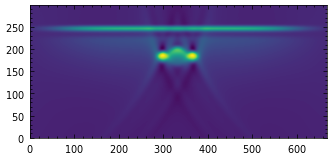

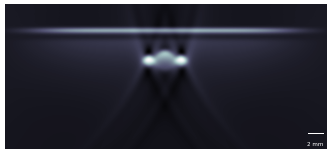

In [5]:
image_data = np.squeeze(reconstructions[0][1].raw_data)

plt.imshow(image_data[0], origin="lower")
plt.show()

reconstructions[0][1].imshow()

In [6]:
mask_skin = np.zeros(image_data.shape[-2:], dtype=bool)
mask_skin[240:250] = True

In [7]:
x = np.arange(image_data.shape[1])
y = np.arange(image_data.shape[2])

mask_artery = (x[:, None] - 182) ** 2 + (y[None, :] - 332) ** 2 < 20**2
mask_vein_1 = (x[:, None] - 182) ** 2 + (y[None, :] - 299) ** 2 < 10**2
mask_vein_2 = (x[:, None] - 182) ** 2 + (y[None, :] - 365) ** 2 < 10**2

In [8]:
df = pd.DataFrame(
    [
        {
            "wavelengths": x[0],
            "artery_spectrum": np.mean(
                np.squeeze(x[1].raw_data).T[mask_artery.T].T, axis=-1
            ),
            "vein_1_spectrum": np.mean(
                np.squeeze(x[1].raw_data).T[mask_vein_1.T].T, axis=-1
            ),
            "vein_2_spectrum": np.mean(
                np.squeeze(x[1].raw_data).T[mask_vein_2.T].T, axis=-1
            ),
            "skin_spectrum": np.mean(
                np.squeeze(x[1].raw_data).T[mask_skin.T].T, axis=-1
            ),
            "artery_so2": np.mean(
                np.squeeze(x[2].raw_data).T[mask_artery.T].T, axis=-1
            ),
            "vein_1_so2": np.mean(
                np.squeeze(x[2].raw_data).T[mask_vein_1.T].T, axis=-1
            ),
            "vein_2_so2": np.mean(
                np.squeeze(x[2].raw_data).T[mask_vein_2.T].T, axis=-1
            ),
            "skin_so2": np.mean(np.squeeze(x[2].raw_data).T[mask_skin.T].T, axis=-1),
            "mvf": x[3],
            "rec": x[1],
            "so2": x[2],
            "thb": x[4],
        }
        for x in reconstructions
    ]
)

In [9]:
fp_min = 0.02
fp_max = 0.4

fps = ["I", "II", "III", "IV", "V", "VI"]

def mvf_to_fp(x):
    return (np.log(x) - np.log(fp_min)) / (np.log(fp_max) - np.log(fp_min)) * 5 + 1


df["fp"] = df["mvf"].apply(mvf_to_fp)


def fix_clims(ims, lower=None, upper=None):
    min_c = np.inf
    max_c = -np.inf
    for i in ims:
        a, b = i.get_clim()
        if min_c > a:
            min_c = a
        if max_c < b:
            max_c = b
    if lower is not None:
        min_c = lower
    if upper is not None:
        max_c = upper
    for i in ims:
        i.set_clim((min_c, max_c))

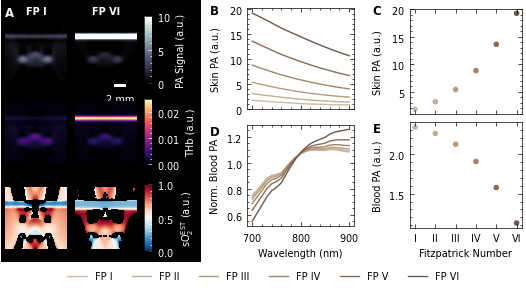

In [10]:
sample_indices = [0, -1]
n_samples = len(sample_indices)

log = False

fig = plt.figure(figsize=(5.25, 1.5 * 5.25 / 3))
subfiga, subfigb = fig.subfigures(1, 2, width_ratios=(1.25, 2))
metric_name = "PA"
output_name = "PA"

subsubfiga, subsubfigb = subfigb.subfigures(1, 2)
# Right plots
ax1, ax2 = subsubfiga.subplots(2)
ax3, ax4 = subsubfigb.subplots(2)

for i, x in df.iterrows():
    ax1.plot(x["wavelengths"], x["skin_spectrum"], color=rgbs[i])
    ax2.plot(
        x["wavelengths"],
        x["artery_spectrum"] / np.mean(x["artery_spectrum"]),
        color=rgbs[i], label="FP " + fps[int(x["fp"]-1)]
    )

ax3.scatter(df["fp"], df["skin_spectrum"].apply(lambda x: x[0]), c=rgbs)
ax4.scatter(df["fp"], df["artery_spectrum"].apply(lambda x: x[0]), c=rgbs)

ax3.set_xticks(np.arange(1, 7), ["I", "II", "III", "IV", "V", "VI"])
ax3.set_xticks([], [], minor=True)
ax4.set_xticks(np.arange(1, 7), ["I", "II", "III", "IV", "V", "VI"])
ax4.set_xticks([], [], minor=True)
ax4.set_xlabel("Fitzpatrick Number")

ax2.sharex(ax1)
ax1.set_ylabel(f"Skin {metric_name} (a.u.)")
ax2.set_ylabel(f"Norm. Blood {metric_name}")
ax2.set_xlabel("Wavelength (nm)")

ax1.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)
ax3.set_ylabel(f"Skin {metric_name} (a.u.)")
ax4.set_ylabel(f"Blood {metric_name} (a.u.)")

subfiga.set_facecolor("k")

im_grid = subfiga.subplots(3, n_samples, sharex=True, sharey=True)


thb_ims = []
ims = []
so2_ims = []

for j in sample_indices:
    ax = im_grid[0, j]
    im = df.iloc[j]["rec"].imshow(ax=ax, scalebar=False)
    ims.append(im)
    ax.set_xlim([-0.005, 0.005])
    ax.set_ylim([-0.0075, 0.0025])
    if j == -1:
        scalebar = ScaleBar(
            1,
            "m",
            length_fraction=0.25,
            width_fraction=0.05,
            color="w",
            box_alpha=0.0,
            location="upper right",
            bbox_to_anchor=(1.0, 0.0),
            bbox_transform=im_grid[0, j].transAxes,
        )
        im_grid[0, j].add_artist(scalebar)

    ax = im_grid[1, j]
    im_thb = df.iloc[j]["thb"].imshow(ax=ax, scalebar=False)
    thb_ims.append(im_thb)
    ax.set_xlim([-0.005, 0.005])
    ax.set_ylim([-0.0075, 0.0025])

    ax = im_grid[2, j]
    r = df.iloc[j]["so2"].raw_data
    r[r < 0] = np.nan
    r[r > 1] = np.nan
    so2_im = df.iloc[j]["so2"].imshow(ax=ax, clim=(0, 1), scalebar=False)
    so2_ims.append(so2_im)
    ax.set_xlim([-0.005, 0.005])
    ax.set_ylim([-0.0075, 0.0025])

fix_clims(ims, upper=10, lower=0)
fix_clims(thb_ims)
fix_clims(so2_ims)

cbar = plt.colorbar(ims[0], ax=im_grid[0], aspect=8)
cbar.set_label("PA Signal (a.u.)", color="w")
cbar.ax.tick_params(color="w", labelcolor="w", which="both")
cbar = plt.colorbar(thb_ims[0], ax=im_grid[1], aspect=8)
cbar.set_label("THb (a.u.)", color="w")
cbar.ax.tick_params(color="w", labelcolor="w", which="both")
cbar = plt.colorbar(so2_ims[0], ax=im_grid[2], aspect=8)
cbar.set_label(r"$\mathrm{sO_2^{EST}}$ (a.u.)", color="w")
cbar.ax.tick_params(color="w", labelcolor="w", which="both")

for i, label_ax in enumerate(im_grid[0]):
    label_ax.annotate(
        "FP " + fps[sample_indices[i]],
        xy=(0.5, 1.05),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize="medium",
        color="w",
        fontweight="bold",
    )

fig.legend(*ax2.get_legend_handles_labels(), loc="upper center", 
           bbox_to_anchor=(0.5, 0), ncols=6)
    
label = add_axis_label(im_grid[0, 0], "A")
label.set_color("w")
add_axis_label(ax1, "B")
add_axis_label(ax3, "C")
add_axis_label(ax2, "D")
add_axis_label(ax4, "E")
subsubfiga.align_labels()
subsubfigb.align_labels()
subfiga.align_labels()
subfigb.align_labels()
fig.align_labels()

plt.savefig(f"../figures/figure_015.pdf", dpi=300)
plt.show()